4 16 718
(4, 718) (16, 4, 718) (718,)


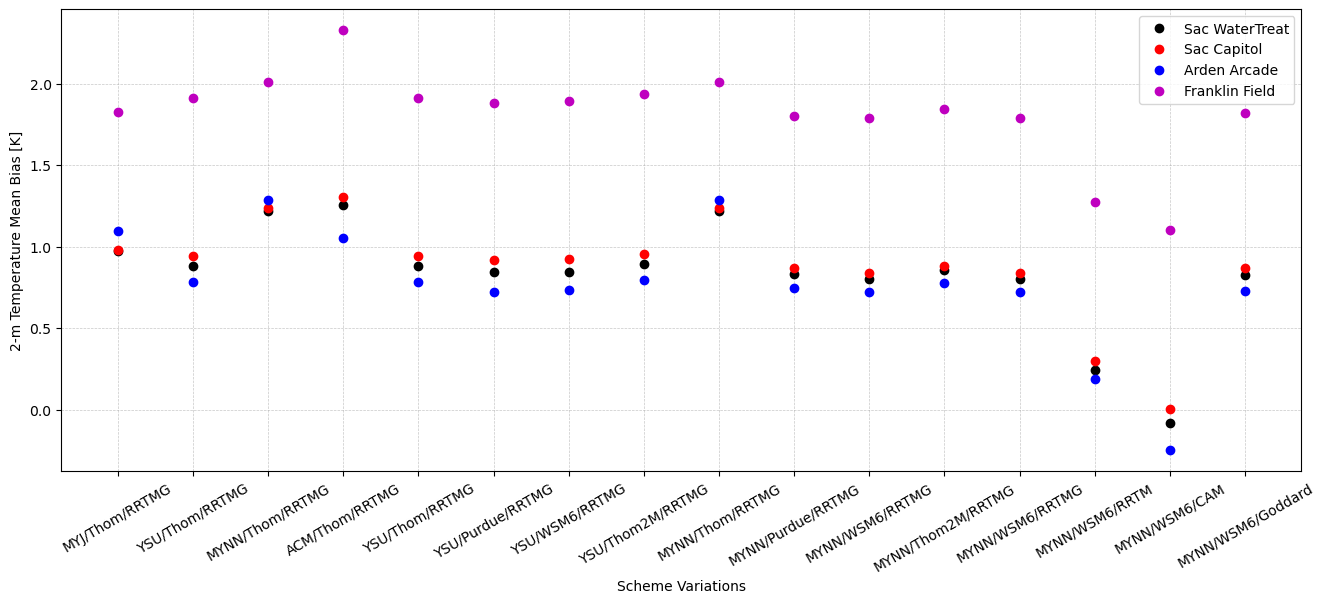

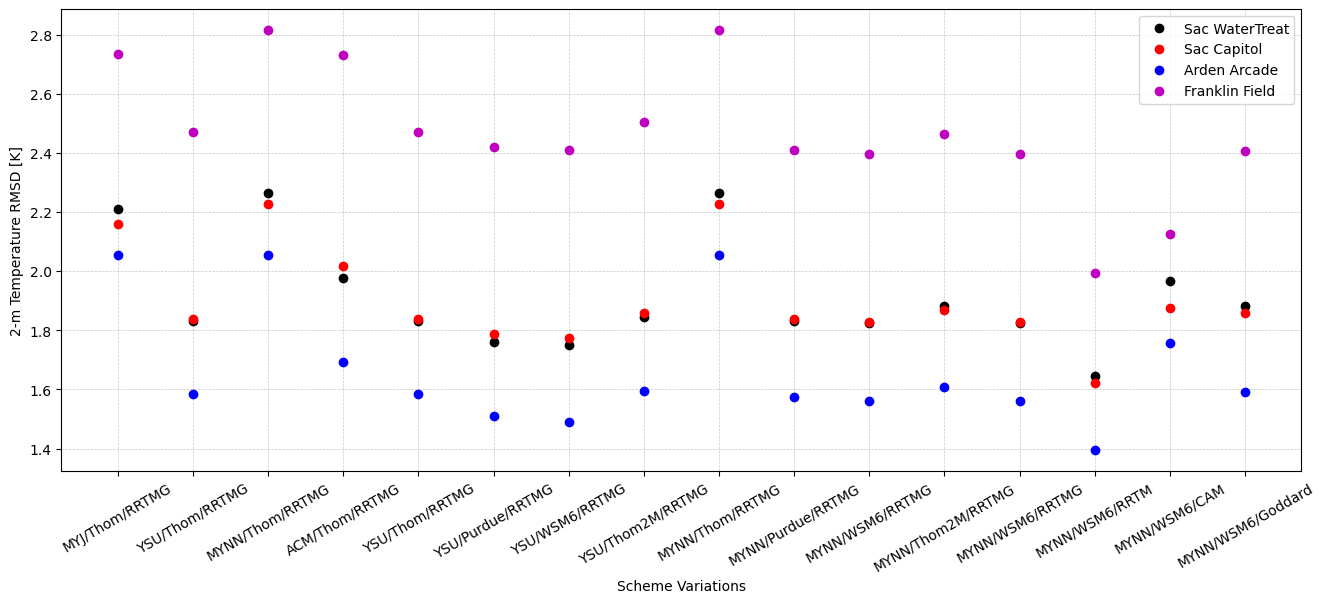

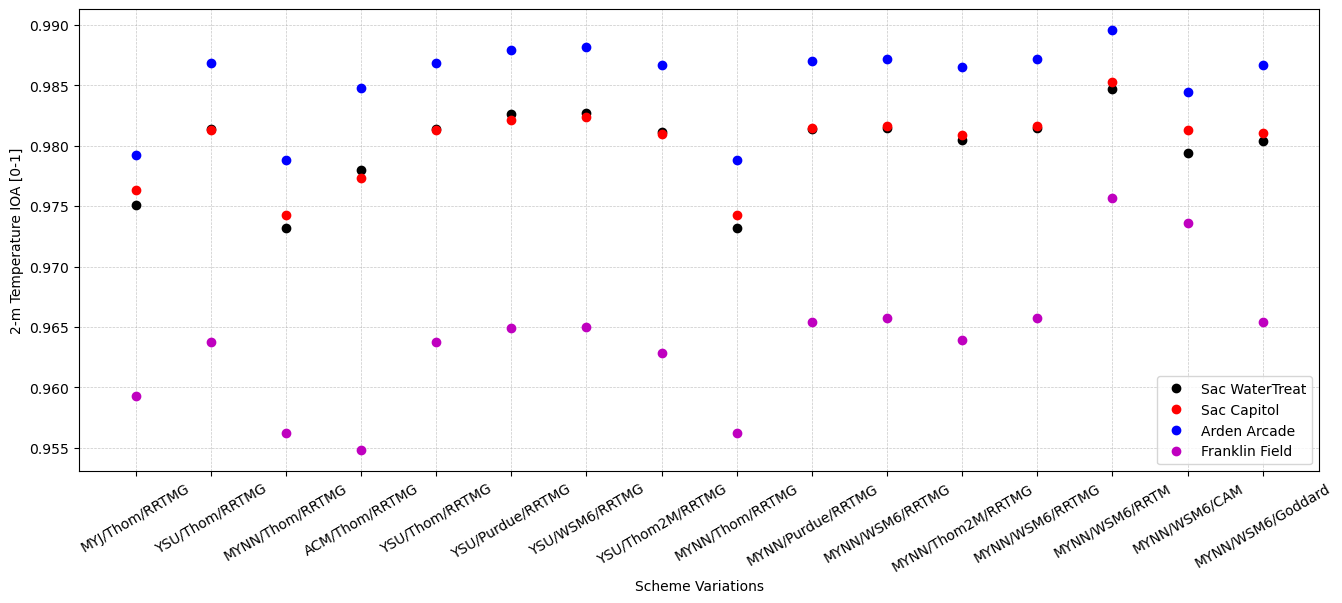

In [1]:
## Loading the Libaries.
from glob import glob
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from wrf import getvar, to_np, ll_to_xy, ALL_TIMES, get_cartopy, latlon_coords, ll_to_xy, vertcross, interplevel,ALL_TIMES
import cartopy as cp

## Load the EPA Data Input File
EPA_files = [
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_Sac.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_SacSoCap.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_ArdenArcade.csv",
    "/data/wto/EPAMetData/hourly_TEMP_2020_06_Franklin.csv"
]
# Load and convert all 4 stations at once → shape (4, n_hours)
EPAVals = np.array([(np.loadtxt(f, delimiter=',', usecols=[13],max_rows=718)-32)*5/9 for f in EPA_files])

#print(len(DataVal))

# === Get the WRF Values for the entire month and for all 4 locations.
WRFVar = "T2"
WRFLocs= [[38.593322,-121.503795],[38.56844,-121.49311],[38.613779,-121.368014],[38.302591,-121.420838]]
WRFFiles = ["/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_250710/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_250714/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_250711/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_250715/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_250714/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP2_250716/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_250718/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP38_250719/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_250711/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP2_250805/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_250730/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP38_250804/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD4_251118/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD1_251120/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD3_251121/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD5_251119/wrfout_d01_2020-06-*"]
WRFTime = None        # will hold the common time axis
WRFVals = []          # shape: [n_folders][n_locs][n_times]

for folder_pattern in WRFFiles:       # loop through each folder
    files = sorted(glob(folder_pattern))
    # Open all files in this folder once
    ncfiles = [Dataset(f) for f in files]

    # Concatenate all times for this variable across files
    var_all = getvar(ncfiles, WRFVar, timeidx=ALL_TIMES, method="cat")
    # var_all dims: ("Time", "south_north", "west_east")

    # Set the global time vector only once (assuming all folders have same times)
    if WRFTime is None:
        # Depending on wrf-python version, Time may be a coord or attribute
        try:
            WRFTime = to_np(var_all["Time"])
        except Exception:
            WRFTime = to_np(var_all.Time)

    # Compute the (x, y) indices for each requested lat/lon ONCE per folder
    loc_indices = []
    first_ds = ncfiles[0]
    for lat, lon in WRFLocs:
        x_idx, y_idx = ll_to_xy(first_ds, lat, lon, as_int=True)
        loc_indices.append((x_idx, y_idx))

    # Extract timeseries for each location
    folder_vals = []   # [n_locs][n_times]
    for (x_idx, y_idx) in loc_indices:
        # var_all: [time, y, x]
        series_K = var_all[:, y_idx, x_idx]
        series_C = to_np(series_K - 273.15)   # convert to °C
        folder_vals.append(series_C)

    WRFVals.append(folder_vals)

    # Close datasets to free resources
    for ds in ncfiles:
        ds.close()

WRFVals = np.array(WRFVals)
WRFTime = np.array(WRFTime)

print(len(EPAVals),len(WRFVals), len(WRFTime))
print(EPAVals.shape,WRFVals.shape,WRFTime.shape)

Biases = []
RMSDs = []
IOAs = []
for iLoc in range(0,EPAVals.shape[0]):
    for iScheme in range(0,WRFVals.shape[0]):
        Diff = WRFVals[iScheme,iLoc]-EPAVals[iLoc]
        Biases.append(np.mean(Diff))
        RMSDs.append(np.sqrt(np.mean(Diff**2)))
        # Calculate Index of Agreement. (Willmott 1981)
        numerator = np.sum((WRFVals[iScheme,iLoc]-EPAVals[iLoc]) ** 2)
        denominator = np.sum((np.abs(WRFVals[iScheme,iLoc] - np.mean(EPAVals[iLoc])) + np.abs(EPAVals[iLoc] - np.mean(EPAVals[iLoc]))) ** 2)
        ioa = 1 - numerator / denominator if denominator != 0 else np.nan
        IOAs.append(ioa)

# The x_labels should be a list of strings
x_labels = [
    'MYJ/Thom/RRTMG',    'YSU/Thom/RRTMG',    'MYNN/Thom/RRTMG',   'ACM/Thom/RRTMG',
    'YSU/Thom/RRTMG',    'YSU/Purdue/RRTMG',  'YSU/WSM6/RRTMG',    'YSU/Thom2M/RRTMG',
    'MYNN/Thom/RRTMG',   'MYNN/Purdue/RRTMG', 'MYNN/WSM6/RRTMG',   'MYNN/Thom2M/RRTMG',
    'MYNN/WSM6/RRTMG',   'MYNN/WSM6/RRTM',    'MYNN/WSM6/CAM',     'MYNN/WSM6/Goddard'
]
NModels=len(x_labels)

plt.figure(figsize=(16, 6))
plt.plot(Biases[0:NModels*1],'.k',ms=12,label="Sac WaterTreat")
plt.plot(Biases[NModels*1:NModels*2],'.r',ms=12,label="Sac Capitol")
plt.plot(Biases[NModels*2:NModels*3],'.b',ms=12,label="Arden Arcade")
plt.plot(Biases[NModels*3:NModels*4],'.m',ms=12,label="Franklin Field")
plt.legend()
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Temperature Mean Bias [K]")
plt.xticks(range(0,NModels), x_labels,rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()
#print(Biases)

plt.figure(figsize=(16, 6))
plt.plot(RMSDs[0:NModels*1],'.k',ms=12,label="Sac WaterTreat")
plt.plot(RMSDs[NModels*1:NModels*2],'.r',ms=12,label="Sac Capitol")
plt.plot(RMSDs[NModels*2:NModels*3],'.b',ms=12,label="Arden Arcade")
plt.plot(RMSDs[NModels*3:NModels*4],'.m',ms=12,label="Franklin Field")
plt.legend()
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Temperature RMSD [K]")
plt.xticks(range(0,NModels), x_labels,rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()
#print(RMSDs)

plt.figure(figsize=(16, 6))
plt.plot(IOAs[0:NModels*1],'.k',ms=12,label="Sac WaterTreat")
plt.plot(IOAs[NModels*1:NModels*2],'.r',ms=12,label="Sac Capitol")
plt.plot(IOAs[NModels*2:NModels*3],'.b',ms=12,label="Arden Arcade")
plt.plot(IOAs[NModels*3:NModels*4],'.m',ms=12,label="Franklin Field")
plt.legend()
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Temperature IOA [0-1]")
plt.xticks(range(0,NModels), x_labels,rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()
#print(IOAs)

4 16 718
(4, 718) (16, 4, 718) (718,)


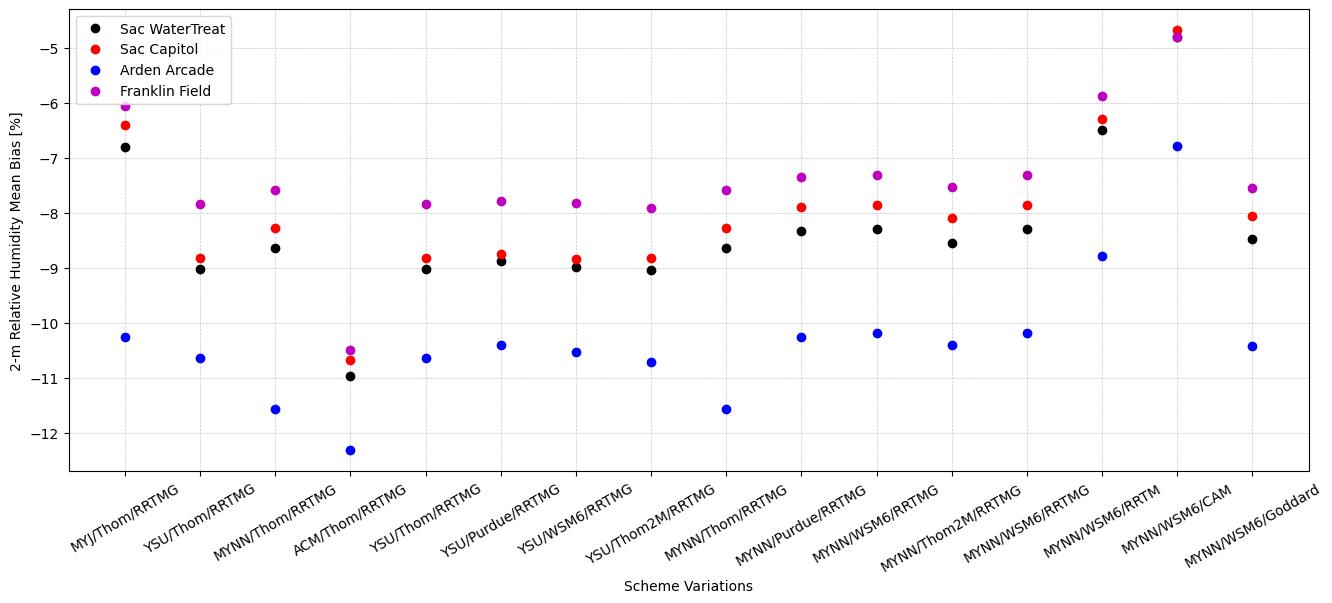

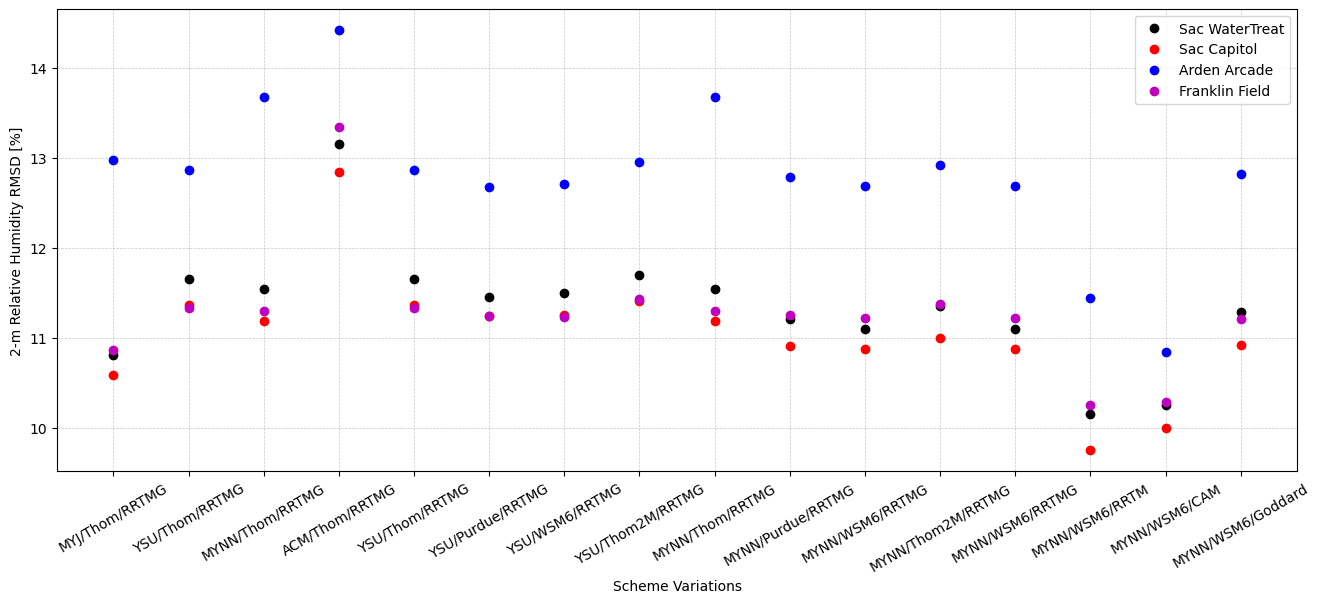

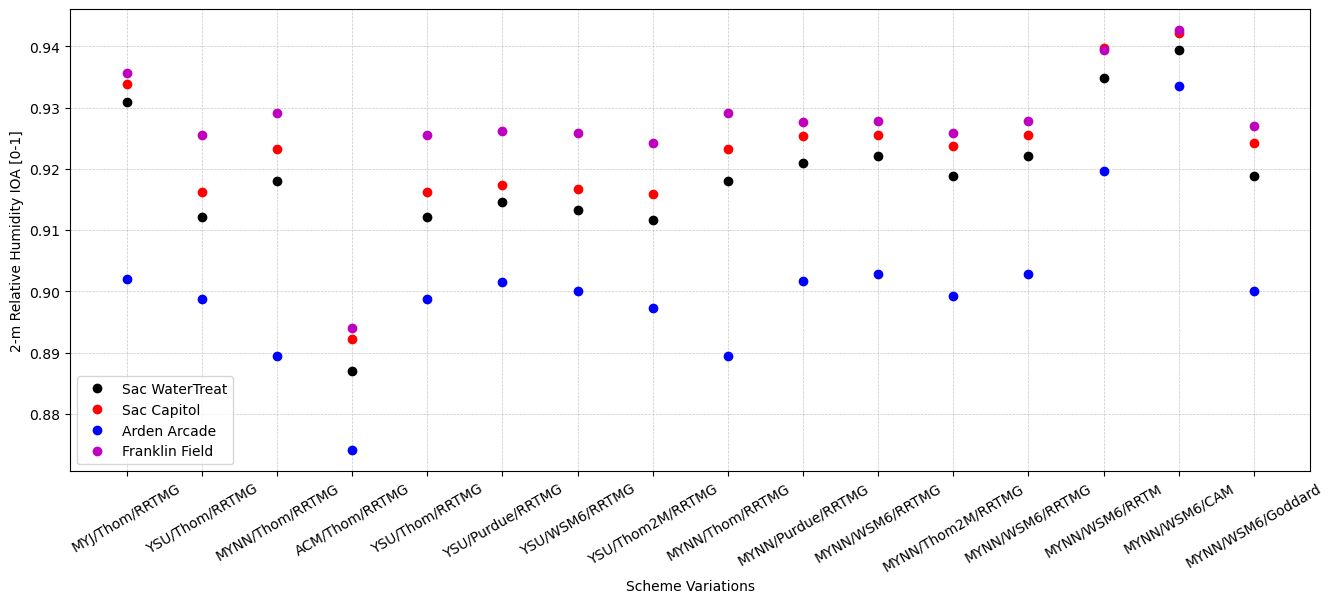

In [2]:
## Loading the Libaries.
from glob import glob
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from wrf import getvar, to_np, ll_to_xy, ALL_TIMES, get_cartopy, latlon_coords, ll_to_xy, vertcross, interplevel,ALL_TIMES
import cartopy as cp

## Load the EPA Data Input File
EPA_files = [
    "/data/wto/EPAMetData/hourly_RH_DP_2020_06_Sac.csv",
    "/data/wto/EPAMetData/hourly_RH_DP_2020_06_SacSoCap.csv",
    "/data/wto/EPAMetData/hourly_RH_DP_2020_06_ArdenArcade.csv",
    "/data/wto/EPAMetData/hourly_RH_DP_2020_06_Franklin.csv"
]
# Load and convert all 4 stations at once → shape (4, n_hours)
EPAVals = np.array([np.loadtxt(f, delimiter=',', usecols=[13],max_rows=718) for f in EPA_files])

#print(len(DataVal))

# === Get the WRF Values for the entire month and for all 4 locations.
WRFVar = "rh2"
WRFLocs= [[38.593322,-121.503795],[38.56844,-121.49311],[38.613779,-121.368014],[38.302591,-121.420838]]
WRFFiles = ["/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_250710/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_250714/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_250711/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_250715/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_250714/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP2_250716/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_250718/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP38_250719/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_250711/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP2_250805/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_250730/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP38_250804/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD4_251118/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD1_251120/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD3_251121/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD5_251119/wrfout_d01_2020-06-*"]
WRFTime = None        # will hold the common time axis
WRFVals = []          # shape: [n_folders][n_locs][n_times]

for folder_pattern in WRFFiles:       # loop through each folder
    files = sorted(glob(folder_pattern))
    # Open all files in this folder once
    ncfiles = [Dataset(f) for f in files]

    # Concatenate all times for this variable across files
    var_all = getvar(ncfiles, WRFVar, timeidx=ALL_TIMES, method="cat")
    # var_all dims: ("Time", "south_north", "west_east")

    # Set the global time vector only once (assuming all folders have same times)
    if WRFTime is None:
        # Depending on wrf-python version, Time may be a coord or attribute
        try:
            WRFTime = to_np(var_all["Time"])
        except Exception:
            WRFTime = to_np(var_all.Time)

    # Compute the (x, y) indices for each requested lat/lon ONCE per folder
    loc_indices = []
    first_ds = ncfiles[0]
    for lat, lon in WRFLocs:
        x_idx, y_idx = ll_to_xy(first_ds, lat, lon, as_int=True)
        loc_indices.append((x_idx, y_idx))

    # Extract timeseries for each location
    folder_vals = []   # [n_locs][n_times]
    for (x_idx, y_idx) in loc_indices:
        # var_all: [time, y, x]
        series_C = var_all[:, y_idx, x_idx]
        folder_vals.append(series_C)

    WRFVals.append(folder_vals)

    # Close datasets to free resources
    for ds in ncfiles:
        ds.close()

WRFVals = np.array(WRFVals)
WRFTime = np.array(WRFTime)

print(len(EPAVals),len(WRFVals), len(WRFTime))
print(EPAVals.shape,WRFVals.shape,WRFTime.shape)

Biases = []
RMSDs = []
IOAs = []
for iLoc in range(0,EPAVals.shape[0]):
    for iScheme in range(0,WRFVals.shape[0]):
        Diff = WRFVals[iScheme,iLoc]-EPAVals[iLoc]
        Biases.append(np.mean(Diff))
        RMSDs.append(np.sqrt(np.mean(Diff**2)))
        # Calculate Index of Agreement. (Willmott 1981)
        numerator = np.sum((WRFVals[iScheme,iLoc]-EPAVals[iLoc]) ** 2)
        denominator = np.sum((np.abs(WRFVals[iScheme,iLoc] - np.mean(EPAVals[iLoc])) + np.abs(EPAVals[iLoc] - np.mean(EPAVals[iLoc]))) ** 2)
        ioa = 1 - numerator / denominator if denominator != 0 else np.nan
        IOAs.append(ioa)

# The x_labels should be a list of strings
x_labels = [
    'MYJ/Thom/RRTMG',    'YSU/Thom/RRTMG',    'MYNN/Thom/RRTMG',   'ACM/Thom/RRTMG',
    'YSU/Thom/RRTMG',    'YSU/Purdue/RRTMG',  'YSU/WSM6/RRTMG',    'YSU/Thom2M/RRTMG',
    'MYNN/Thom/RRTMG',   'MYNN/Purdue/RRTMG', 'MYNN/WSM6/RRTMG',   'MYNN/Thom2M/RRTMG',
    'MYNN/WSM6/RRTMG',   'MYNN/WSM6/RRTM',    'MYNN/WSM6/CAM',     'MYNN/WSM6/Goddard'
]
NModels=len(x_labels)

plt.figure(figsize=(16, 6))
plt.plot(Biases[0:NModels*1],'.k',ms=12,label="Sac WaterTreat")
plt.plot(Biases[NModels*1:NModels*2],'.r',ms=12,label="Sac Capitol")
plt.plot(Biases[NModels*2:NModels*3],'.b',ms=12,label="Arden Arcade")
plt.plot(Biases[NModels*3:NModels*4],'.m',ms=12,label="Franklin Field")
plt.legend()
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Relative Humidity Mean Bias [%]")
plt.xticks(range(0,NModels), x_labels,rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()
#print(Biases)

plt.figure(figsize=(16, 6))
plt.plot(RMSDs[0:NModels*1],'.k',ms=12,label="Sac WaterTreat")
plt.plot(RMSDs[NModels*1:NModels*2],'.r',ms=12,label="Sac Capitol")
plt.plot(RMSDs[NModels*2:NModels*3],'.b',ms=12,label="Arden Arcade")
plt.plot(RMSDs[NModels*3:NModels*4],'.m',ms=12,label="Franklin Field")
plt.legend()
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Relative Humidity RMSD [%]")
plt.xticks(range(0,NModels), x_labels,rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()
#print(RMSDs)

plt.figure(figsize=(16, 6))
plt.plot(IOAs[0:NModels*1],'.k',ms=12,label="Sac WaterTreat")
plt.plot(IOAs[NModels*1:NModels*2],'.r',ms=12,label="Sac Capitol")
plt.plot(IOAs[NModels*2:NModels*3],'.b',ms=12,label="Arden Arcade")
plt.plot(IOAs[NModels*3:NModels*4],'.m',ms=12,label="Franklin Field")
plt.legend()
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Relative Humidity IOA [0-1]")
plt.xticks(range(0,NModels), x_labels,rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()
#print(IOAs)

4 16 718
(4, 718) (16, 4, 718) (718,)


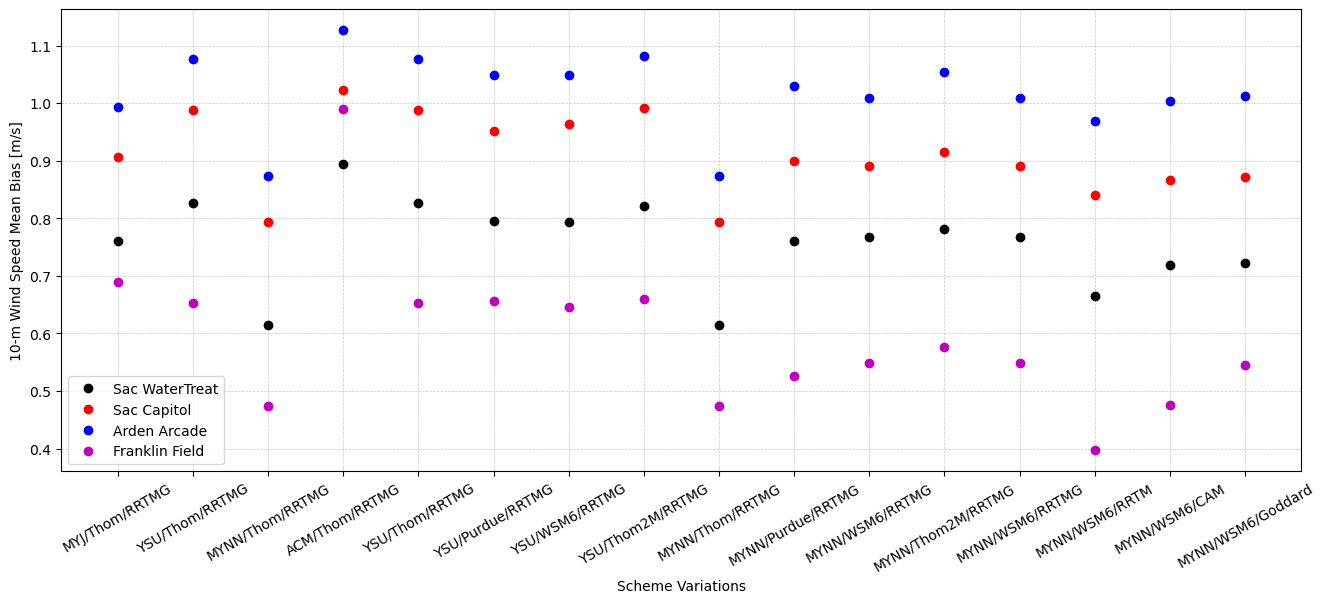

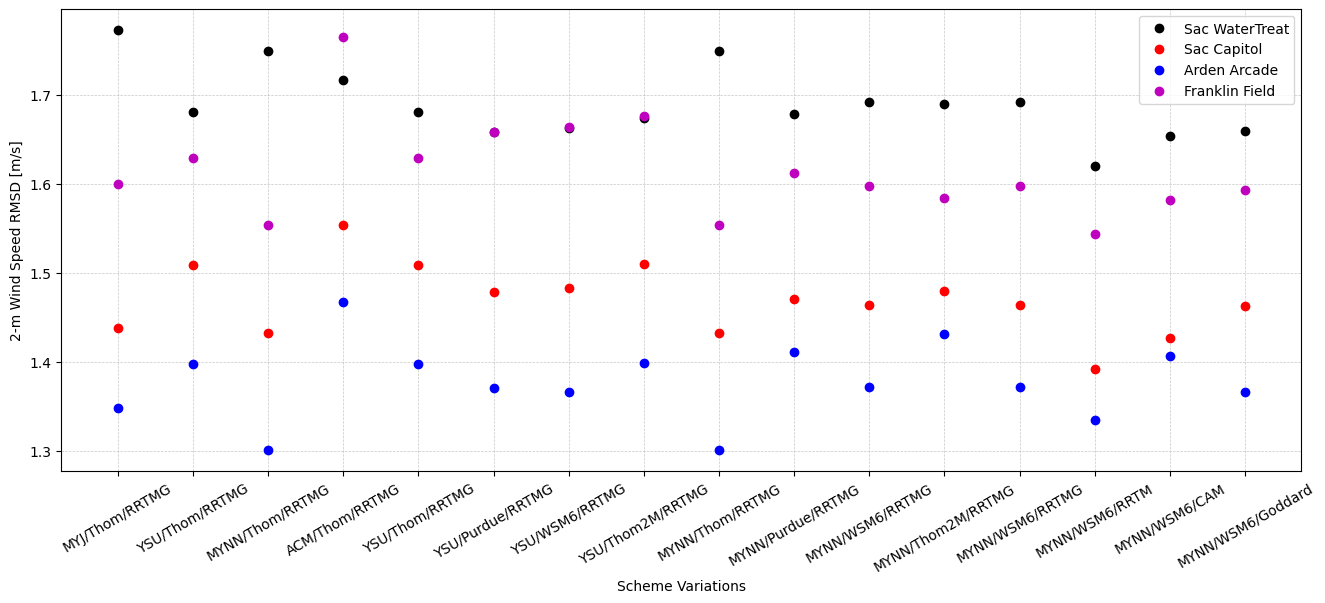

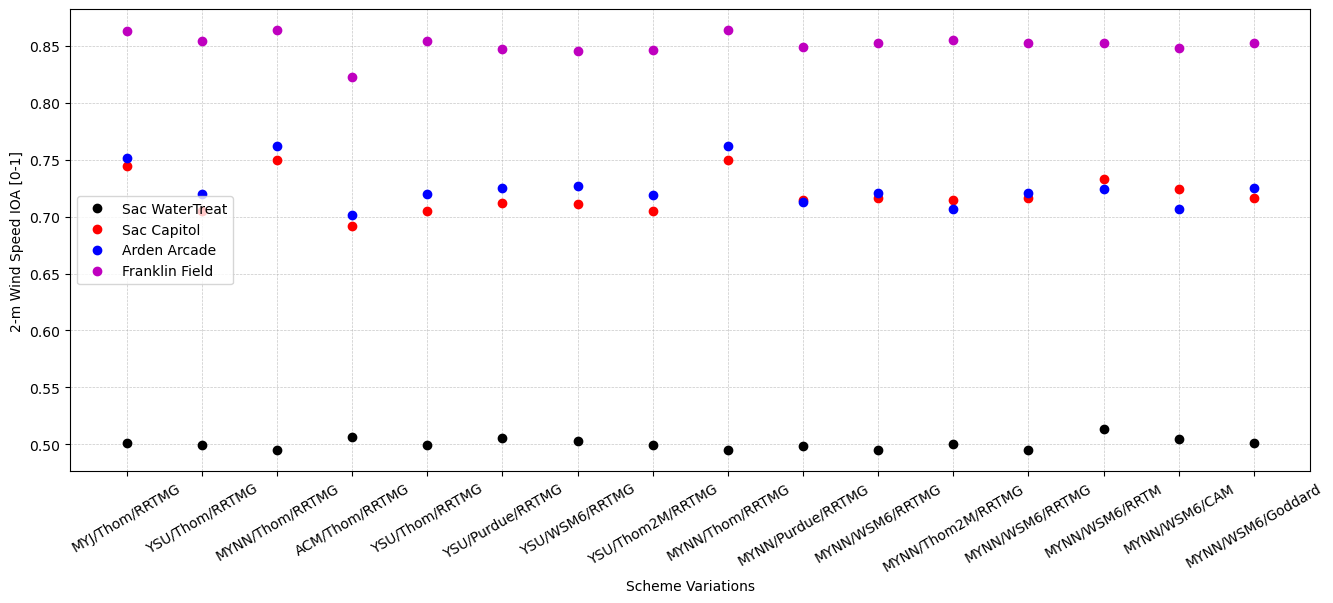

In [3]:
## Loading the Libaries.
from glob import glob
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from wrf import getvar, to_np, ll_to_xy, ALL_TIMES, get_cartopy, latlon_coords, ll_to_xy, vertcross, interplevel,ALL_TIMES
import cartopy as cp

## Load the EPA Data Input File
EPA_files = [
    "/data/wto/EPAMetData/hourly_WINDMAG_2020_06_Sac.csv",
    "/data/wto/EPAMetData/hourly_WINDMAG_2020_06_SacSoCap.csv",
    "/data/wto/EPAMetData/hourly_WINDMAG_2020_06_ArdenArcade.csv",
    "/data/wto/EPAMetData/hourly_WINDMAG_2020_06_Franklin.csv"
]
# Load and convert all 4 stations at once → shape (4, n_hours)
EPAVals = np.array([np.loadtxt(f, delimiter=',', usecols=[13],max_rows=718)*0.514444 for f in EPA_files])

#print(len(DataVal))

# === Get the WRF Values for the entire month and for all 4 locations.
WRFVar = "wspd10"
WRFLocs= [[38.593322,-121.503795],[38.56844,-121.49311],[38.613779,-121.368014],[38.302591,-121.420838]]
WRFFiles = ["/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_250710/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_250714/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_250711/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_250715/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_250714/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP2_250716/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_250718/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP38_250719/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_250711/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP2_250805/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_250730/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP38_250804/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD4_251118/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD1_251120/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD3_251121/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD5_251119/wrfout_d01_2020-06-*"]
WRFTime = None        # will hold the common time axis
WRFVals = []          # shape: [n_folders][n_locs][n_times]

for folder_pattern in WRFFiles:       # loop through each folder
    files = sorted(glob(folder_pattern))
    # Open all files in this folder once
    ncfiles = [Dataset(f) for f in files]

    # Concatenate all times for this variable across files
    var_all = getvar(ncfiles, WRFVar, timeidx=ALL_TIMES, method="cat")
    # var_all dims: ("Time", "south_north", "west_east")

    # Set the global time vector only once (assuming all folders have same times)
    if WRFTime is None:
        # Depending on wrf-python version, Time may be a coord or attribute
        try:
            WRFTime = to_np(var_all["Time"])
        except Exception:
            WRFTime = to_np(var_all.Time)

    # Compute the (x, y) indices for each requested lat/lon ONCE per folder
    loc_indices = []
    first_ds = ncfiles[0]
    for lat, lon in WRFLocs:
        x_idx, y_idx = ll_to_xy(first_ds, lat, lon, as_int=True)
        loc_indices.append((x_idx, y_idx))

    # Extract timeseries for each location
    folder_vals = []   # [n_locs][n_times]
    for (x_idx, y_idx) in loc_indices:
        # var_all: [time, y, x]
        series_C = var_all[:, y_idx, x_idx]
        folder_vals.append(series_C)

    WRFVals.append(folder_vals)

    # Close datasets to free resources
    for ds in ncfiles:
        ds.close()

WRFVals = np.array(WRFVals)
WRFTime = np.array(WRFTime)

print(len(EPAVals),len(WRFVals), len(WRFTime))
print(EPAVals.shape,WRFVals.shape,WRFTime.shape)

Biases = []
RMSDs = []
IOAs = []
for iLoc in range(0,EPAVals.shape[0]):
    for iScheme in range(0,WRFVals.shape[0]):
        Diff = WRFVals[iScheme,iLoc]-EPAVals[iLoc]
        Biases.append(np.mean(Diff))
        RMSDs.append(np.sqrt(np.mean(Diff**2)))
        # Calculate Index of Agreement. (Willmott 1981)
        numerator = np.sum((WRFVals[iScheme,iLoc]-EPAVals[iLoc]) ** 2)
        denominator = np.sum((np.abs(WRFVals[iScheme,iLoc] - np.mean(EPAVals[iLoc])) + np.abs(EPAVals[iLoc] - np.mean(EPAVals[iLoc]))) ** 2)
        ioa = 1 - numerator / denominator if denominator != 0 else np.nan
        IOAs.append(ioa)

# The x_labels should be a list of strings
x_labels = [
    'MYJ/Thom/RRTMG',    'YSU/Thom/RRTMG',    'MYNN/Thom/RRTMG',   'ACM/Thom/RRTMG',
    'YSU/Thom/RRTMG',    'YSU/Purdue/RRTMG',  'YSU/WSM6/RRTMG',    'YSU/Thom2M/RRTMG',
    'MYNN/Thom/RRTMG',   'MYNN/Purdue/RRTMG', 'MYNN/WSM6/RRTMG',   'MYNN/Thom2M/RRTMG',
    'MYNN/WSM6/RRTMG',   'MYNN/WSM6/RRTM',    'MYNN/WSM6/CAM',     'MYNN/WSM6/Goddard'
]
NModels=len(x_labels)

plt.figure(figsize=(16, 6))
plt.plot(Biases[0:NModels*1],'.k',ms=12,label="Sac WaterTreat")
plt.plot(Biases[NModels*1:NModels*2],'.r',ms=12,label="Sac Capitol")
plt.plot(Biases[NModels*2:NModels*3],'.b',ms=12,label="Arden Arcade")
plt.plot(Biases[NModels*3:NModels*4],'.m',ms=12,label="Franklin Field")
plt.legend()
plt.xlabel("Scheme Variations")
plt.ylabel("10-m Wind Speed Mean Bias [m/s]")
plt.xticks(range(0,NModels), x_labels,rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()
#print(Biases)

plt.figure(figsize=(16, 6))
plt.plot(RMSDs[0:NModels*1],'.k',ms=12,label="Sac WaterTreat")
plt.plot(RMSDs[NModels*1:NModels*2],'.r',ms=12,label="Sac Capitol")
plt.plot(RMSDs[NModels*2:NModels*3],'.b',ms=12,label="Arden Arcade")
plt.plot(RMSDs[NModels*3:NModels*4],'.m',ms=12,label="Franklin Field")
plt.legend()
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Wind Speed RMSD [m/s]")
plt.xticks(range(0,NModels), x_labels,rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()
#print(RMSDs)

plt.figure(figsize=(16, 6))
plt.plot(IOAs[0:NModels*1],'.k',ms=12,label="Sac WaterTreat")
plt.plot(IOAs[NModels*1:NModels*2],'.r',ms=12,label="Sac Capitol")
plt.plot(IOAs[NModels*2:NModels*3],'.b',ms=12,label="Arden Arcade")
plt.plot(IOAs[NModels*3:NModels*4],'.m',ms=12,label="Franklin Field")
plt.legend()
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Wind Speed IOA [0-1]")
plt.xticks(range(0,NModels), x_labels,rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()
#print(IOAs)

4 16 718
(4, 718) (16, 4, 718) (718,)


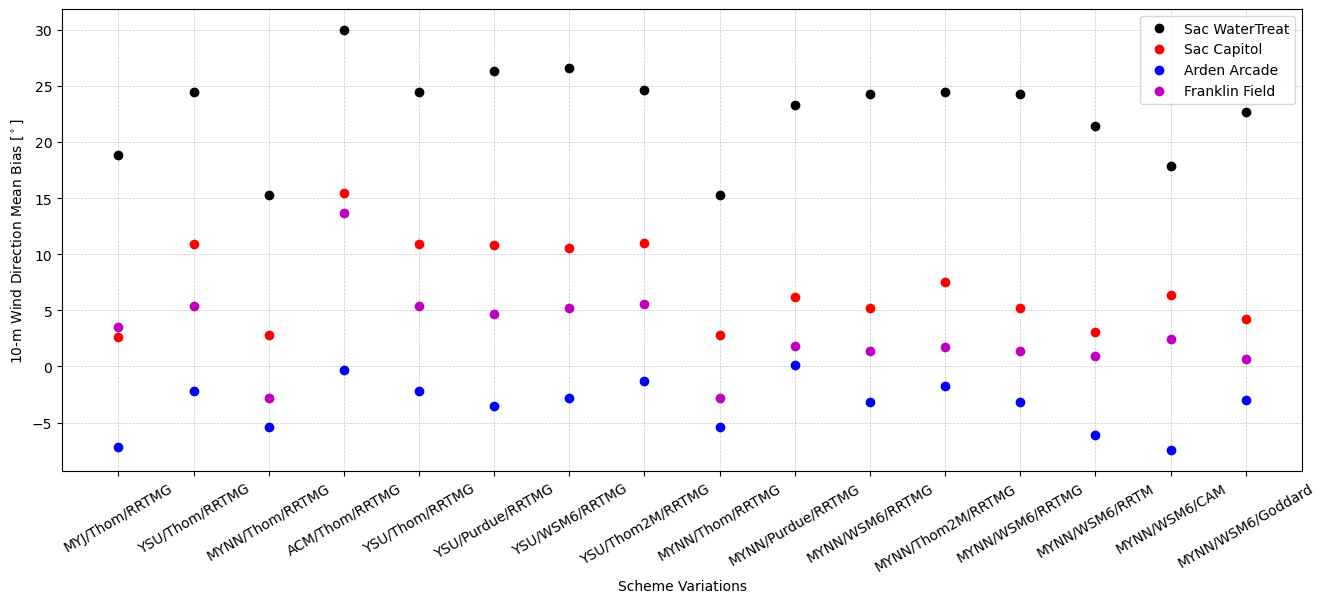

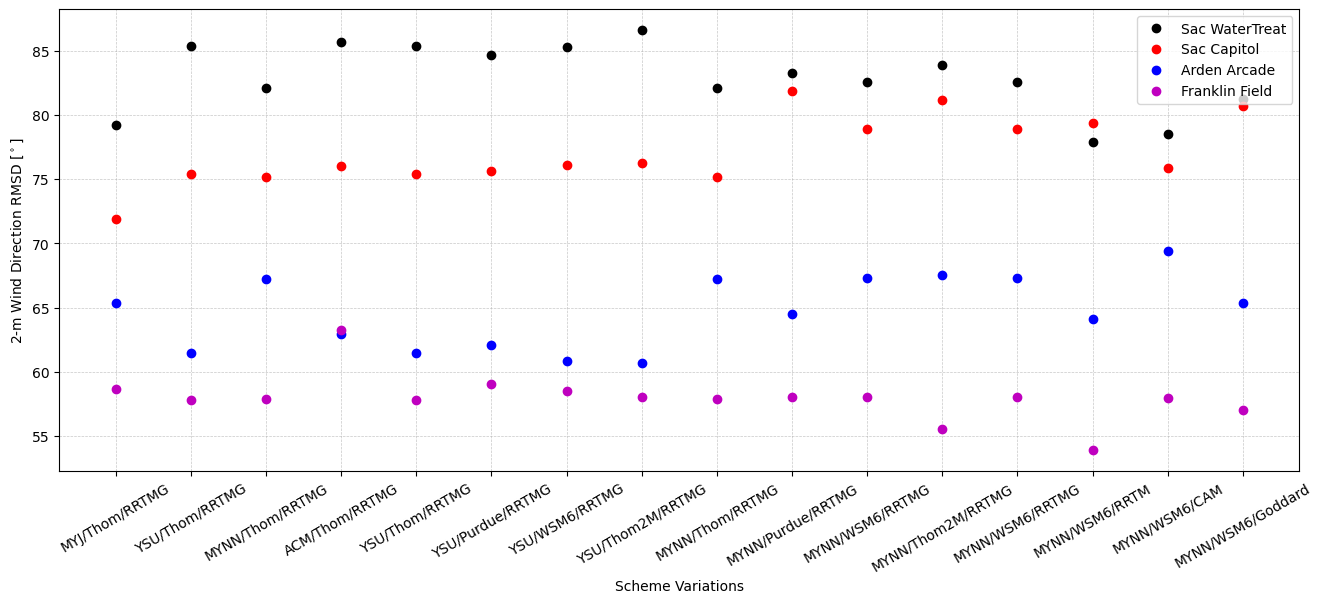

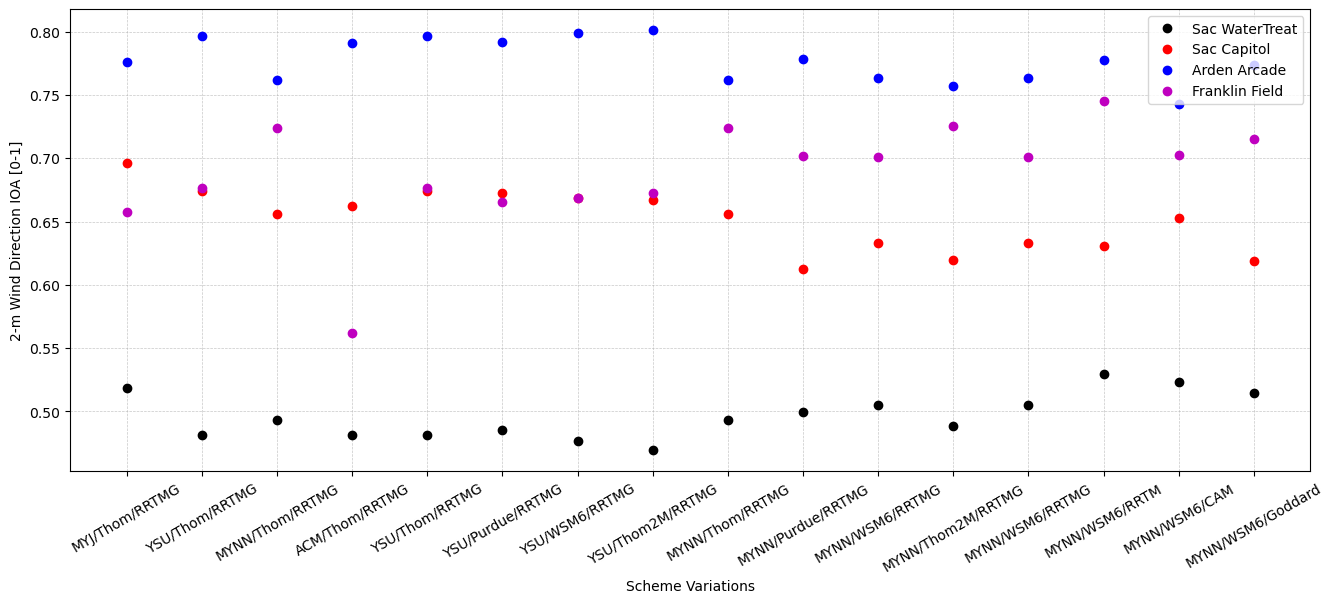

In [4]:
## Loading the Libaries.
from glob import glob
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from wrf import getvar, to_np, ll_to_xy, ALL_TIMES, get_cartopy, latlon_coords, ll_to_xy, vertcross, interplevel,ALL_TIMES
import cartopy as cp

## Load the EPA Data Input File
EPA_files = [
    "/data/wto/EPAMetData/hourly_WINDDIR_2020_06_Sac.csv",
    "/data/wto/EPAMetData/hourly_WINDDIR_2020_06_SacSoCap.csv",
    "/data/wto/EPAMetData/hourly_WINDDIR_2020_06_ArdenArcade.csv",
    "/data/wto/EPAMetData/hourly_WINDDIR_2020_06_Franklin.csv"
]
# Load and convert all 4 stations at once → shape (4, n_hours)
EPAVals = np.array([np.loadtxt(f, delimiter=',', usecols=[13],max_rows=718)for f in EPA_files])

#print(len(DataVal))

# === Get the WRF Values for the entire month and for all 4 locations.
WRFVar = "wdir10"
WRFLocs= [[38.593322,-121.503795],[38.56844,-121.49311],[38.613779,-121.368014],[38.302591,-121.420838]]
WRFFiles = ["/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_250710/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_250714/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_250711/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_250715/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_250714/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP2_250716/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_250718/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP38_250719/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_250711/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP2_250805/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_250730/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP38_250804/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD4_251118/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD1_251120/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD3_251121/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD5_251119/wrfout_d01_2020-06-*"]
WRFTime = None        # will hold the common time axis
WRFVals = []          # shape: [n_folders][n_locs][n_times]

for folder_pattern in WRFFiles:       # loop through each folder
    files = sorted(glob(folder_pattern))
    # Open all files in this folder once
    ncfiles = [Dataset(f) for f in files]

    # Concatenate all times for this variable across files
    var_all = getvar(ncfiles, WRFVar, timeidx=ALL_TIMES, method="cat")
    # var_all dims: ("Time", "south_north", "west_east")

    # Set the global time vector only once (assuming all folders have same times)
    if WRFTime is None:
        # Depending on wrf-python version, Time may be a coord or attribute
        try:
            WRFTime = to_np(var_all["Time"])
        except Exception:
            WRFTime = to_np(var_all.Time)

    # Compute the (x, y) indices for each requested lat/lon ONCE per folder
    loc_indices = []
    first_ds = ncfiles[0]
    for lat, lon in WRFLocs:
        x_idx, y_idx = ll_to_xy(first_ds, lat, lon, as_int=True)
        loc_indices.append((x_idx, y_idx))

    # Extract timeseries for each location
    folder_vals = []   # [n_locs][n_times]
    for (x_idx, y_idx) in loc_indices:
        series_C = var_all[:, y_idx, x_idx]
        folder_vals.append(series_C)

    WRFVals.append(folder_vals)

    # Close datasets to free resources
    for ds in ncfiles:
        ds.close()

WRFVals = np.array(WRFVals)
WRFTime = np.array(WRFTime)

print(len(EPAVals),len(WRFVals), len(WRFTime))
print(EPAVals.shape,WRFVals.shape,WRFTime.shape)

Biases = []
RMSDs = []
IOAs = []
for iLoc in range(0,EPAVals.shape[0]):
    for iScheme in range(0,WRFVals.shape[0]):
        Diff = WRFVals[iScheme,iLoc]-EPAVals[iLoc]
        Biases.append(np.mean(Diff))
        RMSDs.append(np.sqrt(np.mean(Diff**2)))
        # Calculate Index of Agreement. (Willmott 1981)
        numerator = np.sum((WRFVals[iScheme,iLoc]-EPAVals[iLoc]) ** 2)
        denominator = np.sum((np.abs(WRFVals[iScheme,iLoc] - np.mean(EPAVals[iLoc])) + np.abs(EPAVals[iLoc] - np.mean(EPAVals[iLoc]))) ** 2)
        ioa = 1 - numerator / denominator if denominator != 0 else np.nan
        IOAs.append(ioa)

# The x_labels should be a list of strings
x_labels = [
    'MYJ/Thom/RRTMG',    'YSU/Thom/RRTMG',    'MYNN/Thom/RRTMG',   'ACM/Thom/RRTMG',
    'YSU/Thom/RRTMG',    'YSU/Purdue/RRTMG',  'YSU/WSM6/RRTMG',    'YSU/Thom2M/RRTMG',
    'MYNN/Thom/RRTMG',   'MYNN/Purdue/RRTMG', 'MYNN/WSM6/RRTMG',   'MYNN/Thom2M/RRTMG',
    'MYNN/WSM6/RRTMG',   'MYNN/WSM6/RRTM',    'MYNN/WSM6/CAM',     'MYNN/WSM6/Goddard'
]
NModels=len(x_labels)

plt.figure(figsize=(16, 6))
plt.plot(Biases[0:NModels*1],'.k',ms=12,label="Sac WaterTreat")
plt.plot(Biases[NModels*1:NModels*2],'.r',ms=12,label="Sac Capitol")
plt.plot(Biases[NModels*2:NModels*3],'.b',ms=12,label="Arden Arcade")
plt.plot(Biases[NModels*3:NModels*4],'.m',ms=12,label="Franklin Field")
plt.legend()
plt.xlabel("Scheme Variations")
plt.ylabel("10-m Wind Direction Mean Bias [$^\circ$]")
plt.xticks(range(0,NModels), x_labels,rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()
#print(Biases)

plt.figure(figsize=(16, 6))
plt.plot(RMSDs[0:NModels*1],'.k',ms=12,label="Sac WaterTreat")
plt.plot(RMSDs[NModels*1:NModels*2],'.r',ms=12,label="Sac Capitol")
plt.plot(RMSDs[NModels*2:NModels*3],'.b',ms=12,label="Arden Arcade")
plt.plot(RMSDs[NModels*3:NModels*4],'.m',ms=12,label="Franklin Field")
plt.legend()
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Wind Direction RMSD [$^\circ$]")
plt.xticks(range(0,NModels), x_labels,rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()
#print(RMSDs)

plt.figure(figsize=(16, 6))
plt.plot(IOAs[0:NModels*1],'.k',ms=12,label="Sac WaterTreat")
plt.plot(IOAs[NModels*1:NModels*2],'.r',ms=12,label="Sac Capitol")
plt.plot(IOAs[NModels*2:NModels*3],'.b',ms=12,label="Arden Arcade")
plt.plot(IOAs[NModels*3:NModels*4],'.m',ms=12,label="Franklin Field")
plt.legend()
plt.xlabel("Scheme Variations")
plt.ylabel("2-m Wind Direction IOA [0-1]")
plt.xticks(range(0,NModels), x_labels,rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()
#print(IOAs)